---
title: "Modelo LDA para la clasificación de contratos de obra"
author: "Mauricio Roverssi Alvarado"
date: "2023-04-23"
version: "1.0"
---

# Modelo LDA para la clasificación de contratos de obra

## Introducción

Este notebook contiene el código para la creación del modelo LDA para la clasificación de contratos de obra. El modelo se crea a partir de los datos de los contratos de obra del SECOP II. Se utiliza la librería Gensim para la creación del modelo y la librería pyLDAvis para la visualización de los resultados.

Secciones del notebook:
1. Cargar librerías
2. Funciones
3. Carga de datos - Detalle del objeto a contratar
4. Creación del diccionario
5. Creación del corpus
6. Creación del modelo LDA
7. Búsqueda del número óptimo de tópicos con coherence score
8. Modelo LDA Optimizado
9. Método para incluir bigramas y trigramas en el modelo
10. Función para visualizar los tópicos con perplejidad

## Cargar librerías

In [3]:
# Librerias

import csv
import pandas as pd
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.utils import deaccent

from nltk.corpus import stopwords

lista_stopwords = stopwords.words("spanish")

import spacy

# Cargar el modelo de spacy para el idioma español
nlp = spacy.load("es_core_news_md")

# Importadas por JP
import time
from pprint import pprint
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Funciones

In [4]:
# Funciones

## Función para abrir e iterar el archivo de los contratos linea por linea

def iter_csv_file(filename, column_name):
    """
    Esta función toma un archivo CSV y el nombre de una columna y devuelve un iterador que
    produce los valores de esa columna para cada fila en el archivo.

    Argumentos:
        filename (str): El nombre del archivo CSV a leer.
        column_name (str): El nombre de la columna en la que queremos iterar.

    Yields:
        El valor de la columna especificada para cada fila en el archivo.

    Ejemplo de uso:

    >>> for value in iter_csv_file('datos.csv', 'edad'):
            print(value)

        27
        35
        42
        18
        ...
    """
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            yield row[column_name]

## Función para iterar la fila de una columna de un dataframe linea por linea, se utiliza para generar el corpus

def iter_dataframe(df, column_name):
    """
    Esta función toma un DataFrame de pandas y el nombre de una columna y devuelve un iterador que
    produce los tokens lematizados para cada fila en la columna especificada.

    Argumentos:
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        column_name (str): El nombre de la columna en la que queremos iterar.

    Yields:
        Una lista de los tokens lematizados para cada fila en la columna especificada.
    """
    for line in df[column_name]:
        # Tokeniza la línea utilizando simple_preprocess y se eliminan las palabras menores a 3 letras y los acentos
        tokens = simple_preprocess(line, deacc=True, min_len=3)
        # Se remueven las stopwords y las palabras que aparecen solo una vez antes de aplicar la lematización
        doc = [token for token in nlp(' '.join(tokens).lower()) if token.text not in lista_stopwords]
        yield [token.lemma_ for token in doc]


## Función para iterar una columna y devolver una lista de lemas se utiliza para generar el diccionario



def iter_column(df, col_name):
    """
    Esta función toma un DataFrame de pandas y el nombre de una columna y devuelve un iterador que
    produce una lista de lemas para cada línea en la columna especificada.

    Argumentos:
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        col_name (str): El nombre de la columna en la que queremos iterar.

    Yields:
        Una lista de lemas para cada línea en la columna especificada.

    Ejemplo de uso:

    >>> for lemmas in iter_column(df, 'texto'):
            print(lemmas)

        ['comprar', 'manzana', 'pera', 'naranja']
        ['ir', 'cine', 'amigo']
        ['cocinar', 'comida', 'saludable', 'cena']
        ...
    """
    # Itera sobre cada línea en la columna especificada
    for line in df[col_name]:
        # Se eliminan los acentos de las palabras en la línea utilizando unidecode
        # Tokeniza la línea utilizando simple_preprocess
        tokens = simple_preprocess(line, deacc=True,min_len=3)
        # Se remueven las stopwords y las palabras que aparecen solo una vez antes de aplicar la lematización
        doc = [token for token in nlp(' '.join(tokens).lower()) if token.text not in lista_stopwords]
        # Itera sobre cada token en el objeto Doc y devuelve su forma lematizada utilizando el atributo lemma_
        lemmas = [token.lemma_ for token in doc]
        lemmas = [deaccent(lemma) for lemma in lemmas]
        # Genera una lista de lemas para cada línea en la columna de entrada utilizando la sentencia yield
        yield lemmas


## Función para crear el corpus a partir de todos los datos

class MyCorpus():
    """
    Esta clase es una implementación de la interfaz de corpus de Gensim, que define cómo se accede a los documentos en un corpus de texto.
    """

    # Constructor de la clase MyCorpus
    def __init__(self, dictionary):
        """
        Constructor de la clase MyCorpus.

        Argumentos:
        dictionary (gensim.corpora.Dictionary): Objeto de diccionario de Gensim que se utilizará para crear bolsas de palabras.
        """
        self.dictionary = dictionary

    # Método que devuelve un generador que produce bolsas de palabras para cada línea en el archivo CSV
    def __iter__(self):
        """
        Método que devuelve un generador que produce bolsas de palabras para cada línea en el archivo CSV.

        Yields:
        Una bolsa de palabras para cada línea en el archivo CSV.
        """
        # Itera sobre cada línea en el archivo CSV utilizando el método iter_csv_file
        for line in iter_csv_file('datos/df_secop_obra.csv', 'Detalle_Objeto_Contratar'):
            # Convierte la lista de lemas en una bolsa de palabras utilizando el método doc2bow de self.dictionary
            yield self.dictionary.doc2bow(line.split())


# Función para crear el corpus a partir de la muestra
class MyCorpus_sample():
    """
    Esta clase es una implementación de la interfaz de corpus de Gensim, que define cómo se accede a los documentos en un corpus de texto.
    """

    # Constructor de la clase MyCorpus
    def __init__(self, dictionary, df, column_name):
        """
        Constructor de la clase MyCorpus.

        Argumentos:
        dictionary (gensim.corpora.Dictionary): Objeto de diccionario de Gensim que se utilizará para crear bolsas de palabras.
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        column_name (str): El nombre de la columna en el que queremos iterar.
        """
        self.dictionary = dictionary
        self.df = df
        self.column_name = column_name

    # Método que devuelve un generador que produce bolsas de palabras para cada línea en el dataframe
    def __iter__(self):
        """
        Método que devuelve un generador que produce bolsas de palabras para cada línea en el dataframe.

        Yields:
        Una bolsa de palabras para cada línea en el dataframe.
        """
        # Itera sobre cada línea en el dataframe utilizando el método iter_dataframe
        for line in iter_dataframe(self.df, self.column_name):
            # Convierte la lista de lemas en una bolsa de palabras utilizando el método doc2bow de self.dictionary
            yield self.dictionary.doc2bow(' '.join(line).split())


## Carga de datos - Objeto de contratos

In [6]:
# Se carga el archivo csv con los datos de los contratos
datos = pd.read_csv('datos/df_secop_obra.csv', encoding='utf-8', low_memory=False)

## Pasar la columna Detalle_Objeto_Contratar de object a string porque sino da un error
datos['Detalle_Objeto_Contratar']=datos['Detalle_Objeto_Contratar'].astype(str)

In [7]:
conteo_minimo = 2000
datos_filtrados = datos.groupby(['Objeto_Contratar']).filter(lambda x: x['UID'].count() >= conteo_minimo)
datos_filtrados.groupby(['Objeto_Contratar']).count()['UID']

Objeto_Contratar
Componentes y Suministros para Estructuras, Edificación, Construcción y Obras Civiles     21290
Componentes, Accesorios y Suministros de Sistemas Eléctricos e Iluminación                 2233
Servicios Basados en Ingeniería, Investigación y Tecnología                               15188
Servicios Medioambientales                                                                 3920
Servicios Públicos y Servicios Relacionados con el Sector Público                          7323
Servicios de Contratacion Agrícola, Pesquera, Forestal y de Fauna                          3558
Servicios de Edificación, Construcción de Instalaciones y Mantenimiento                  240479
Servicios de Gestion, Servicios Profesionales de Empresa y Servicios Administrativos       9399
Servicios de Limpieza, Descontaminación y Tratamiento de Residuos                          3418
Servicios de Salud                                                                         2251
Terrenos, Edificios, Es

In [9]:
datos_filtrados

,Unnamed: 0,UID,Anno_Cargue_SECOP,Anno_Firma_Contrato,Nivel_Entidad,Orden_Entidad,Tipo_Proceso,Estado_Proceso,Objeto_Contratar,Detalle_Objeto_Contratar,...,Cuantia_Contrato,Valor_Contrato_Total,Objeto_Contrato_firmado,Moneda,Departamento_Entidad,Cuantia_Proceso_Int,Cuantia_Contrato_Int,Valor_Contrato_Total_Int,Anno_Inicio_Contrato,Anno_Fin_Contrato
0,0,12-13-11849991161831,2012,2012,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1,Contratación Mínima Cuantía,Liquidado,"Servicios de Edificación, Construcción de Inst...",ADQUISICIÓN E INSTALACIÓN DE SEÑALES VERTICALE...,...,"25,377,412","25,377,412",ADQUISICIÓN E INSTALACIÓN DE SEÑALES VERTICALE...,No Definido,Caldas,36000000,25377412,25377412,2012,2012
2,2,14-13-28759002772313,2014,2014,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Contratación Mínima Cuantía,Liquidado,"Servicios de Edificación, Construcción de Inst...",A TODO COSTO MANTENIMIENTO RUTINARIO EN LASAN ...,...,"28,945,026","28,945,026",A TODO COSTO MANTENIMIENTO RUTINARIO EN LASAN ...,No Definido,Huila,32263056,28945026,28945026,2014,2015
3,3,20-4-1134513110490822,2020,2020,TERRITORIAL,DISTRITO CAPITAL,Régimen Especial,Celebrado,"Servicios de Edificación, Construcción de Inst...",PINTURA DE CANCHAS DE BALONCESTO PINTURA DE OR...,...,"4,312,000","4,312,000",PINTURA DE CANCHAS DE BALONCESTO PINTURA DE OR...,Peso Colombiano,Bogotá D.C.,4312000,4312000,4312000,2020,2020
4,4,19-12-95693708710647,2019,2019,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Contratación Directa (Ley 1150 de 2007),Celebrado,"Terrenos, Edificios, Estructuras y Vías",AUNAR ESFUERZOS ENTRE LA ASOCIACIÓN DE MUNICIP...,...,"139,800,000","154,867,240",AUNAR ESFUERZOS ENTRE LA ASOCIACIÓN DE MUNICIP...,Peso Colombiano,Antioquia,139800000,139800000,154867240,2019,2019
5,5,21-4-1204477511157402,2021,2021,TERRITORIAL,DISTRITO CAPITAL,Régimen Especial,Celebrado,"Servicios de Edificación, Construcción de Inst...",Pavimentación en concreto de un area de 94M2 f...,...,"9,165,000","9,165,000",Pavimentación en concreto de un area de 94M2 f...,Peso Colombiano,Bogotá D.C.,9200000,9165000,9165000,2021,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377481,377481,13-11-21773302085040,2013,2014,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Selección Abreviada de Menor Cuantía (Ley 1150...,Liquidado,"Terrenos, Edificios, Estructuras y Vías",ADECUACIÓN DEL POLIDEPORTIVO VEREDA DOÑA JUANA...,...,"19,311,068","19,311,068",ADECUACIÓN DEL POLIDEPORTIVO VEREDA DOÑ...,No Definido,Nariño,19465806,19311068,19311068,2014,2014
377482,377482,14-1-1300573136082,2014,2015,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Licitación Pública,Liquidado,"Servicios de Edificación, Construcción de Inst...",Pavimentación con mezcla densa en caliente y c...,...,"220,372,832","330,419,772",Pavimentación con mezcla densa en caliente y c...,No Definido,Cundinamarca,220446906,220372832,330419772,2015,2015
377483,377483,14-11-30722692945366,2014,2014,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Selección Abreviada de Menor Cuantía (Ley 1150...,Celebrado,"Terrenos, Edificios, Estructuras y Vías",CONSTRUCCION DE PLACA HUELLA EN LA VEREDA PUL...,...,"55,000,000","55,000,000",CONSTRUCCION DE PLACA HUELLA EN LA VEREDA PUL...,No Definido,Cundinamarca,50000000,55000000,55000000,2014,2014
377484,377484,11-12-497648534914,2011,2011,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Contratación Directa (Ley 1150 de 2007),Liquidado,"Servicios de Edificación, Construcción de Inst...",AUNAR ESFUERZOS TECNICOS ADMINISTRATIVOS Y FIN...,...,"40,000,000","40,000,000",AUNAR ESFUERZOS TECNICOS ADMINISTRATIVOS Y FIN...,No Definido,Bogotá D.C.,40000000,40000000,40000000,2011,2011


### Crear la muestra

In [11]:
## Crear la muestra
datos_sample= datos_filtrados.sample(n=18000, random_state=25) #42
#datos_sample= datos[datos['Objeto_Contratar'] == 'Servicios de Salud'].sample(n=1800, random_state=7) # Revisión JP
#datos_sample= datos[datos['Objeto_Contratar'] != 'Servicios de Edificación, Construcción de Instalaciones y Mantenimiento'].sample(n=1800, random_state=25)

## Crear el diccionario

### Stopwords asociadas a departamentos y municipios

In [14]:
# Lectura de la información de archivo departamentos

df_dpto = pd.read_csv('datos/Regiones_Departamentos.csv', sep=';')
df_dpto = list(iter_column(df_dpto, 'Dpto_SECOP'))
lista_dpto = []
for i in df_dpto:
    lista_dpto = lista_dpto + i
lista_dpto = list(set(lista_dpto))

# Lectura de la información de archivo municipios

df_municipio = pd.read_csv('datos/Departamentos_y_municipios_de_Colombia.csv', sep=',')
df_municipio = list(iter_column(df_municipio, 'MUNICIPIO'))
lista_municipio = []
for i in df_municipio:
    lista_municipio = lista_municipio + i
lista_municipio = list(set(lista_municipio))

### Crear diccionaro - Retirar Stopword

In [15]:
## Crear el diccionario con la muestra

dictionary = corpora.Dictionary(iter_column(datos_sample, 'Detalle_Objeto_Contratar'))
#dictionary.filter_extremes(no_above=0.7) # Agregado por JP

once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]


departamento_list =  ['amazonas', 'antioquia', 'arauca', 'atlantico', 'bolivar', 'boyaca', 'caldas', 'caqueta', 'casanare', 'cauca', 'cesar', 'choco', 'cordoba', 'cundinamarca', 'guainia', 'guaviare', 'huila', 'la_guajira', 'magdalena', 'meta', 'narino', 'norte_de_santander', 'putumayo','quindio', 'risaralda', 'san_andres_y_providencia', 'santander', 'sucre', 'tolima', 'valle_del_cauca', 'vaupes', 'vichada']


stoplist=['municipio', 'municipal', 'departamento', 'san', 'jose',  'urbano','rural', 'realizar','vereda', 'calle', 'carrera', 'sector'] ##Incluir otras palabras
stoplist= stoplist + ['santa', 'corregimiento', 'norte', 'esfuerzo', 'aunar', 'locativa', 'sur', 'oriente', 'occidente',
                      'segun', 'jurisdiccion', 'barrio', 'etapa', 'casco', 'contrato', 'contratar',
                      'realizar', 'convenio', 'marco', 'plan', 'apoyo', 'ubicado', 'area', 'centro', 'sector',
                      'mediante', 'sitio', 'area', 'sede'] # Agregadas por JP

stoplist= stoplist + lista_dpto + lista_municipio


#Generar una sola lista de palabras a filtrar
stoplist = stoplist+departamento_list

#Extraer los ids de las palabras de la listas de stoplist que coinciden con las palabras del diccionario
stop_ids = [
    dictionary.token2id[stopword]
    for stopword in stoplist
    if stopword in dictionary.token2id
]

#Funcion de filtrado

dictionary.filter_tokens( once_ids+stop_ids)

print(dictionary)

Dictionary<6805 unique tokens: ['abuelo', 'acueducto', 'aledano', 'almacenamiento', 'bocatoma']...>


# Crear corpuos con la muestra

In [16]:
## Crear corpus con la muestra
corpus_sample= MyCorpus_sample(dictionary, datos_sample,'Detalle_Objeto_Contratar' )

# Crear modelo LDA

# Busqueda de tópicos


In [17]:
# Crear los docucumentos preprocesados que se utilizarán para el calculo de la coherencia
preprocessed_docs = list(iter_dataframe(datos_sample, 'Detalle_Objeto_Contratar'))


In [18]:
# Librerías para el cálculo de la coherencia
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

## Creación de la función para encontrar el número óptimo de tópicos con coherencia

In [19]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def find_optimal_number_of_topics_coherence(data, dictionary, preprocessed_docs, start=2, end=20, step=1, coherence_measure='c_v', coherence_topn=10, workers=None):
    """
    Encuentra el número óptimo de tópicos en un modelo LDA.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - preprocessed_docs: una lista de listas de tokens lematizados para cada documento.
    - start: el número de tópicos mínimo a evaluar.
    - end: el número de tópicos máximo a evaluar.
    - step: el intervalo de valores entre cada número de tópicos a evaluar.
    - coherence_measure: un string con el nombre de la medida de coherencia a utilizar (por defecto 'c_v').
    - coherence_topn: un número entero que indica la cantidad de palabras más relevantes a considerar para la medida de coherencia.
    - workers: el número de núcleos a utilizar para el entrenamiento del modelo LDA (por defecto None, que utiliza todos los núcleos disponibles).

    Retorna:
    - Un gráfico de línea que muestra la medida de coherencia del modelo para cada valor de num_topics evaluado.
    - El modelo LDA óptimo.
    """

    coherence_scores = []
    models_list = []

    # Experimentar con diferentes valores de chunksize
    num_cores = workers if workers else os.cpu_count()
    chunk_sizes = [1000, 5000, 10000]
    chunk_size = chunk_sizes[0]
    for cs in chunk_sizes:
        if len(data) / cs > num_cores:
            chunk_size = cs
            break
    print("Chunk size: ", chunk_size)

    for num_topics in range(start, end+1, step):
        lda_model = LdaMulticore(corpus=data,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 alpha=0.1,
                                 eta=0.5,
                                 random_state=42,
                                 workers=workers,
                                 chunksize=chunk_size)

        coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=preprocessed_docs,
                                             dictionary=dictionary,
                                             coherence=coherence_measure,
                                             topn=coherence_topn)

        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_lda)
        models_list.append(lda_model)

    # Plot coherence scores
    x = range(start, end+1, step)
    plt.plot(x, coherence_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    # Find the optimal number of topics
    optimal_num_topics = x[coherence_scores.index(max(coherence_scores))]

    # Print the optimal number of topics
    print("Optimal number of topics: ", optimal_num_topics)

    # Return the models list and coherence scores
    return models_list[optimal_num_topics-start], coherence_scores


In [20]:
# Establecer el número de núcleos a utilizar
num_cores = 6
workers = num_cores


In [13]:
start = 2
end = 20
step = 1
coherence_measure = 'c_v'
coherence_topn = 10
workers = num_cores

In [38]:
import numpy as np
import random
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

def optimize_lda_parameters_random(data, dictionary, corpus, num_topics_range, alpha_range, eta_range, chunksize_range, passes_range, iterations_range, coherence_measure='c_v', coherence_topn=10, workers=1, min_frequency=5, n_searches=30):
    low_freq_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq < min_frequency]
    dictionary.filter_tokens(bad_ids=low_freq_ids)

    coherence_scores = []
    best_coherence_score = -np.inf
    best_params = {}

    for _ in range(n_searches):
        num_topics = random.choice(num_topics_range)
        alpha = random.choice(alpha_range)
        eta = random.choice(eta_range)
        chunksize = random.choice(chunksize_range)
        passes = random.choice(passes_range)
        iterations = random.choice(iterations_range)

        lda_multicore_model = LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           alpha=alpha,
                                           eta=eta,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           workers=workers)

        coherence_model_lda = CoherenceModel(model=lda_multicore_model,
                                             texts=data,
                                             dictionary=dictionary,
                                             coherence=coherence_measure,
                                             topn=coherence_topn)

        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append((num_topics, alpha, eta, chunksize, passes, iterations, coherence_lda))

        if coherence_lda > best_coherence_score:
            best_coherence_score = coherence_lda
            best_lda_multicore_model = lda_multicore_model
            best_params = {'num_topics': num_topics,
                           'alpha': alpha,
                           'eta': eta,
                           'chunksize': chunksize,
                           'passes': passes,
                           'iterations': iterations}

    return best_lda_multicore_model, best_params, coherence_scores



In [22]:
from gensim.models import TfidfModel
tfidf_model = TfidfModel(corpus_sample)
corpus_tfidf = list(tfidf_model[corpus_sample])

In [24]:
num_topics_range = range(4, 15)  # Rango de número de tópicos de 2 a 20
alpha_range = list(np.arange(0.01, 1.01, 0.1)) + ['symmetric', 'asymmetric']
eta_range = list(np.arange(0.01, 1.01, 0.1)) + ['auto']
chunksize_range =  [1000]  # Rango de tamaño de bloques de 100 a 2000 con incrementos de 100
passes_range = range(1, 11)  # Rango de pases de 1 a 10
iterations_range = range(50, 501, 50)  # Rango de iteraciones de 50 a 500 con incrementos de 50


In [ ]:

best_lda_multicore_model, best_params, coherence_scores = optimize_lda_parameters_random(preprocessed_docs,
                                                                                         dictionary,
                                                                                         corpus_tfidf,
                                                                                         num_topics_range,
                                                                                         alpha_range,
                                                                                         eta_range,
                                                                                         chunksize_range,
                                                                                         passes_range,
                                                                                         iterations_range,
                                                                                         coherence_measure='c_v',
                                                                                         coherence_topn=10,
                                                                                         workers=5,
                                                                                         min_frequency= 5,
                                                                                         n_searches=10)

In [ ]:
print("Mejor modelo LdaMulticore encontrado:")
print(best_lda_multicore_model)
print("\nMejores parámetros:")
print(best_params)

Chunk size:  1000


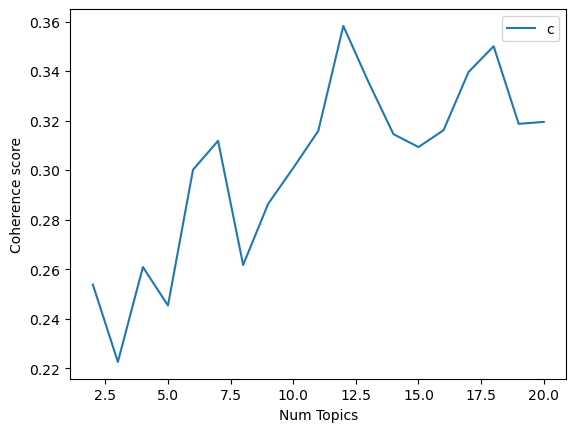

Optimal number of topics:  12


In [87]:
models_list, coherence_scores = find_optimal_number_of_topics_coherence(data=corpus_tfidf,
                                                              dictionary=dictionary,
                                                              preprocessed_docs=preprocessed_docs,
                                                              start=2,
                                                              end=20,
                                                              step=1,
                                                              coherence_measure='c_v',
                                                              coherence_topn=10,
                                                              workers=6)

In [93]:
lda_model = LdaMulticore(corpus=corpus_sample,
                         id2word=dictionary,
                         num_topics=5,
                         alpha=0.1,
                         eta=0.5,
                         random_state=42,
                         workers=6,
                         chunksize=1000)

In [39]:
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(optimal_lda_model, corpus_tfidf, dictionary)

pyLDAvis.save_html(LDA_visualization, 'optimal_lda_modeltfid3.HTML')

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [56]:
# Obtener los términos más relevantes de un tópico específico
topic_id = 11

top_terms = optimal_lda_model.show_topic(topic_id)

# Mostrar los términos y las probabilidades asociadas a ese tópico
print(f"Términos más relevantes del tópico {topic_id}:")
for term, prob in top_terms:
    print(f"{term}: {prob}")


Términos más relevantes del tópico 11:
via: 0.03135078772902489
programa: 0.007427555974572897
conservacion: 0.00703568896278739
terciaria: 0.0051388065330684185
conducir: 0.004752665292471647
rehabilitacion: 0.004557172767817974
ubicado: 0.0041550276800990105
centro: 0.0035651891957968473
veredar: 0.003466419642791152
convenio: 0.0034316168166697025


In [61]:
# Obtener las probabilidades de tópicos para cada documento en el corpus
corpus_topic_probs = []
for doc in corpus_tfidf:
    doc_topic_probs = [prob for topic_id, prob in optimal_lda_model.get_document_topics(doc)]
    corpus_topic_probs.append(doc_topic_probs)

In [62]:
# Obtener los índices de los documentos que no contienen el tópico que deseas eliminar
doc_ids_to_keep = [doc_id for doc_id, doc_topic_probs in enumerate(corpus_topic_probs) if doc_topic_probs[topic_id] < 0.5]

Chunk size:  1000


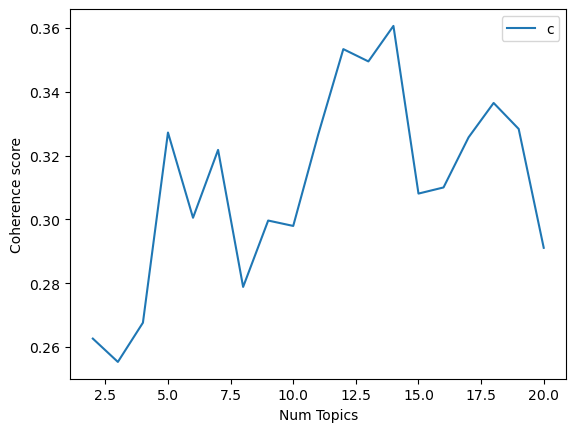

Optimal number of topics:  14


In [64]:
# Filtrar los documentos para mantener solo aquellos que no contienen el tópico que deseas eliminar
corpus_filtered = [corpus_tfidf[doc_id] for doc_id in doc_ids_to_keep]

# Entrenar un nuevo modelo LDA utilizando los documentos filtrados
optimal_lda_model, coherence_scores = find_optimal_number_of_topics_coherence(corpus_filtered, dictionary, preprocessed_docs, start, end, step, coherence_measure, coherence_topn, workers)

In [65]:
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(optimal_lda_model, corpus_tfidf, dictionary)

pyLDAvis.save_html(LDA_visualization, 'optimal_lda_modeltfid4.HTML')

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [18]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
import matplotlib.pyplot as plt

def find_optimal_number_of_topics_perplexity(data, dictionary, preprocessed_docs, start=2, end=20, step=1, workers=None):
    """
    Encuentra el número óptimo de tópicos en un modelo LDA utilizando la medida de perplejidad.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - preprocessed_docs: una lista de listas de tokens lematizados para cada documento.
    - start: el número de tópicos mínimo a evaluar.
    - end: el número de tópicos máximo a evaluar.
    - step: el intervalo de valores entre cada número de tópicos a evaluar.
    - workers: el número de núcleos a utilizar para el entrenamiento del modelo LDA (por defecto None, que utiliza todos los núcleos disponibles).

    Retorna:
    - El modelo LDA entrenado con el número óptimo de tópicos encontrado.
    - Una lista con los scores de perplejidad del modelo para cada valor de num_topics evaluado.
    """

    perplexity_scores = []
    models_list = []

    # Experimentar con diferentes valores de chunk_size
    chunk_sizes = [1000, 5000, 10000]
    chunk_size = chunk_sizes[0]
    for cs in chunk_sizes:
        if len(list(data)) / cs > 6:
            chunk_size = cs
            break

    for num_topics in range(start, end+1, step):
        lda_model = LdaMulticore(corpus=data,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42,
                                 workers=workers,
                                 chunksize=chunk_size)

        perplexity_lda = lda_model.log_perplexity(data)
        perplexity_scores.append(perplexity_lda)
        models_list.append(lda_model)

    # Find the optimal number of topics
    optimal_num_topics = start + perplexity_scores.index(min(perplexity_scores))
    optimal_lda_model = models_list[perplexity_scores.index(min(perplexity_scores))]

    # Plot perplexity scores
    x = range(start, end+1, step)
    plt.plot(x, perplexity_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.legend(("perplexity_values"), loc='best')
    plt.show()

    # Print the optimal number of topics
    print("Optimal number of topics: ", optimal_num_topics)

    # Return the optimal model and perplexity scores
    return optimal_lda_model, perplexity_scores


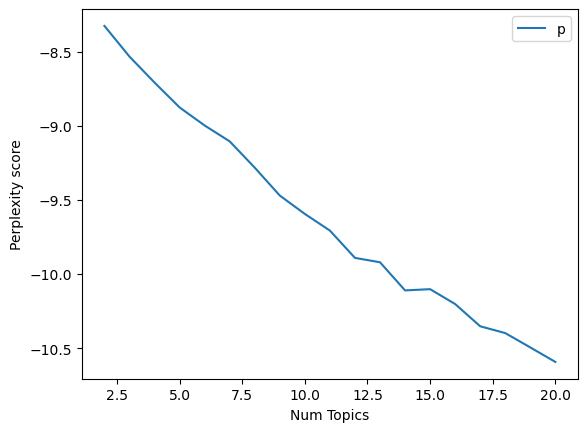

Optimal number of topics:  20


In [40]:
modelo_optimo, scores_perplejidad  = find_optimal_number_of_topics_perplexity(corpus_tfidf, dictionary, preprocessed_docs, start, end, step, workers)

In [82]:
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(modelo_optimo, list(corpus_sample), dictionary)

pyLDAvis.save_html(LDA_visualization, 'optimal_p1.HTML')

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
modelo_optimo1= optimize_lda_hyperparams(datos_sample, dictionary, preprocessed_docs, 10, [0.01, 0.1, 1], [0.01, 0.1, 1])


Chunk size:  1000


In [85]:
documents = find_documents_with_token(corpus_sample, dictionary, 'educativo')


['CONSTRUCCIÓN Y MANTENIMIENTO DE LOS CERRAMIENTOS DE CENTROS EDUCATIVOS RURALES DEL MUNICIPIO DE CHOCONTÁ CUNDINAMARCA',
 'ADECUACION GENERAL DE LA INFRAESTRUCTURA FISICA DEL CENTRO EDUCATIVO CARLOS PALAO OSPINA NUCLEO EDUCATIVO NUMERO 1 DE LA SECRETARIA DE EDUCACION Y CULTURA DE VICHADA',
 'AMPLIACION Y MANTENIMIENTO INSTALACIONES EDUCATIVAS',
 'OBRAS DE MANTENIMIENTO Y ADECUACION DE PARQUE Y ALBERCA DE ALMACENAMIENTO DE AGUA EN LA INSTITUCION EDUCATIVA DEL CORREGIMIENTO DE PITA',
 'PRESTAR  EL  SERVICIO  DE  TRANSPORTE  ESCOLAR  TERRESTREPARA  GARANTIZAR  EL ACCESO  Y  LA PERMANENCIA  AL SISTEMA EDUCATIVO  OFICIAL  DE  LOS  ESTUDIANTES  DEL ÁREA  RURAL YURBANA DEL MUNICIPIO DE YOPAL',
 'MEJORAMIENTO Y ADECUACIÓN DE LA PLANTA FÍSICA EXISTENTE EN LA INSTITUCIÓN EDUCATIVA TÉCNICO AGROPECUARIO OPCION PESCA',
 'PINTURA Y ADECUACIÓN DE AULA MULTIPLE ÁREA ADMINISTRATIVA Y SALONES CENTRALES DE LA INSTITUCIÓN EDUCATIVA ISMAEL RODRIGUEZ FUENTES EN EL MUNICIPIO DE EL MOLINO DEPARTAMENTO DE LA 

In [95]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def optimize_lda_hyperparams(data, dictionary, preprocessed_docs, num_topics, alpha_list, eta_list):
    """
    Optimiza los hiperparámetros alpha y eta para un modelo LDA dado un número fijo de tópicos.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - preprocessed_docs: una lista de listas de tokens lematizados para cada documento.
    - num_topics: el número de tópicos fijo a utilizar en el modelo LDA.
    - alpha_list: una lista de posibles valores para el hiperparámetro alpha.
    - eta_list: una lista de posibles valores para el hiperparámetro eta.

    Retorna:
    - Un modelo LDA entrenado con los mejores valores de alpha y eta encontrados.
    """

    best_coherence = -1
    best_alpha = None
    best_eta = None
    best_model = None
    coherence_scores = []

    # Experimentar con diferentes valores de chunksize
    num_cores = workers if workers else os.cpu_count()
    chunk_sizes = [1000, 5000, 10000]
    chunk_size = chunk_sizes[0]
    for cs in chunk_sizes:
        if len(data) / cs > num_cores:
            chunk_size = cs
            break
    print("Chunk size: ", chunk_size)

    for alpha in alpha_list:
        for eta in eta_list:
            # Entrenar un modelo LDA con los valores actuales de alpha y eta
            lda_model = LdaMulticore(corpus=data,
                                     id2word=dictionary,
                                     num_topics=num_topics,
                                     alpha=alpha,
                                     eta=eta,
                                     random_state=42,
                                     workers=6,
                                     chunksize=chunk_size)

            # Calcular la medida de coherencia del modelo
            coherence_model = CoherenceModel(model=lda_model,
                                             texts=preprocessed_docs,
                                             dictionary=dictionary,
                                             coherence='c_v',
                                             topn=10)

            coherence = coherence_model.get_coherence()
            coherence_scores.append(coherence)

            # Almacenar los mejores valores de alpha, eta y modelo
            if coherence > best_coherence:
                best_coherence = coherence
                best_alpha = alpha
                best_eta = eta
                best_model = lda_model

    # Imprimir los mejores valores de alpha, eta y chunk_size
    print(f"Best alpha: {best_alpha}, Best eta: {best_eta}, Best chunk_size: {chunk_size}")

    # Plot coherence scores
    x = range(len(alpha_list)*len(eta_list))
    plt.plot(x, coherence_scores)
    plt.xlabel("Parameter combinations")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    return best_model

In [56]:
# Identificar el índice del token "via" en el diccionario
via_token_id = dictionary.token2id['via']

# Recorrer el corpus y buscar documentos que contengan el token "via"
for doc_i, doc in enumerate(corpus):
    if any(token_id == via_token_id for token_id, _ in doc):
        # Obtener el texto del documento
        doc_text = datos_sample.iloc[doc_i]['Detalle_Objeto_Contratar']
        # Resaltar todas las ocurrencias de la palabra "via" en el texto
        highlighted_text = doc_text.replace('via', '\033[1mvia\033[0m')
        # Imprimir el texto resaltado
        print(highlighted_text)

CONSTRUCCIÓN CERRAMIENTO PERIMETRAL Y OBRAS COMPLEMENTARIAS CANAL AGUAS LLUVIAS EN EL SECTOR PROGRAMA DE VIVIENDA PRIMERO DE OCTUBRE RECONSTRUCCIÓN YO AMPLIACIÓN DEL CERRAMIENTO PERIMETRAL YO CANAL AGUAS LLUVIAS EN SECTORES DE LOS BARRIOS LA CASCADA LA PRIMAVERA GAITÁN Y LA VEREDA ACEITE ALTO DEL MUNICIPIO DE TAURAMENA DEPARTAMENTO CASANARE
CONSTRUCCIÓN PRIMERA ETAPA DE PAVIMENTO EN CONCRETO ASFALTICO  DE LA CALLE 12 ENTRE CARRERAS 29 Y 35 DEL MUNICIPIO DE ACACIASMETA
MANO DE OBRA OBRAS CIVILES DE REPARCHEO EN ASFALTO CAJEO IMPRIMACIÓN CORTES RETIRO DE SOBRANTES
Contratar las obras de establecimiento de cerca inerte para la conservación y restauración del bosque protector amortiguador de la microcuenca hidrográfica abastecedora de los acueductos veredales de San Nicolás  El Edén y de la vereda San Pablo del municipio de Aguadas Caldas
CONSTRUCCIÓN Y MANTENIMIENTO DE LOS CERRAMIENTOS DE CENTROS EDUCATIVOS RURALES DEL MUNICIPIO DE CHOCONTÁ CUNDINAMARCA
ADECUACION GENERAL DE LA INFRAESTRU

KeyboardInterrupt: 

In [58]:

# Identificar el índice del token "vereda" en el diccionario
vereda_token_id = dictionary.token2id['vereda']

# Recorrer el corpus y buscar documentos que contengan el token "vereda"
for doc_i, doc in enumerate(corpus_sample) :
    if any(token_id == vereda_token_id for token_id, _ in doc):
        # Obtener el texto del documento
        doc_text = datos_sample.iloc[doc_i]['Detalle_Objeto_Contratar']
        # Resaltar todas las ocurrencias de la palabra "vereda" en el texto
        highlighted_text = doc_text.replace('vereda', '\033[1mvereda\033[0m')
        # Imprimir el texto resaltado
        print(highlighted_text)

Contratar las obras de establecimiento de cerca inerte para la conservación y restauración del bosque protector amortiguador de la microcuenca hidrográfica abastecedora de los acueductos veredales de San Nicolás  El Edén y de la vereda San Pablo del municipio de Aguadas Caldas
CONTRATO DE OBRA ADECUACIÓN CAMINO VEREDAL SECTOR QUEBRADA HONDA VEREDA BETANIA MUNICIPIO DE MALLAMA NARIÑO
MANTENIMIENTO RUTINARIO DE VIAS TERCIARIAS DESDE EL ALTO DE LAS IGUANAS VEREDA BOQUERON PASANDO POR EL CRUCE CASA BONITA  MANGON TAJOMEDIO HASTA EL CHORRILLO JURISDICCION DEL MUNICIPIO DE AMBALEMA TOLIMA
FORTALECIMIENTO DEL SISTEMA DE ACUEDUCTO EN SU CAPTACION CONDUCCION TRATAMIENTO MEDICION Y TRANSFERENCIA CON LA CONSTRUCCION POZO PROFUNDO VEREDA GUAMAL Y MANTENIMIENTOS POZO PROFUNDO VEREDA LA CHAMBA DEL MUNICIPIO DE EL GUAMO TOLIMA
INSTALACIÓN DE UN SISTEMA DE RIEGO POR GOTEO Y FERTIRRIEGO PARA 6 LOTES DE CAFÉ EN IGUAL NÚMERO DE FINCAS EN DIFERENTES VEREDAS DEL MUNICIPIO DE PITAL HUILA
ADECUACIÓN DE LA VÍ

In [59]:
# Identificar el índice del token "calle" en el diccionario
calle_token_id = dictionary.token2id['calle']

# Recorrer el corpus y buscar documentos que contengan el token "calle"
for doc_i, doc in enumerate(corpus_sample):
    if any(token_id == calle_token_id for token_id, _ in doc):
        # Obtener el texto del documento
        doc_text = datos_sample.iloc[doc_i]['Detalle_Objeto_Contratar']
        # Resaltar todas las ocurrencias de la palabra "calle" en el texto
        highlighted_text = doc_text.replace('calle', '\033[1mcalle\033[0m')
        # Imprimir el texto resaltado
        print(highlighted_text)

CONSTRUCCIÓN PRIMERA ETAPA DE PAVIMENTO EN CONCRETO ASFALTICO  DE LA CALLE 12 ENTRE CARRERAS 29 Y 35 DEL MUNICIPIO DE ACACIASMETA
PAVIMENTACION CALLES BARRIO PEDRO DAZA Y REPOSICION DE REDES DE ALCANTARILLADO SANITARIO EN EL BARRIO PEDRO DAZA Y BARRIO LA CAMPIÑA EN EL MUNICIPIO DE SAN MARTIN DE LOS LLANOS  DEPARTAMENTO DEL META
Contratar la adquisición adecuación e instalación del mobiliario y suministro de elementos necesarios para la implementación de la red de cableado estructurado red eléctrica normal y regulada centro de cableado cuarto de comunicaciones UPS y RACK que requiere la oficina que funcionará como sede principal de la Región Administrativa y de Planeación Especial RAPE Región Central ubicada  en la Av calle 26 No 59  51  Edificio Cámara Colombiana de la Infraestructura Oficina 702 en Bogotá DC
CONSTRUCCIÓN DE LAS OBRAS DE URBANISMO PARA LA CREACION DEL CALLEJON DEL ENSUEÑO UBICADO EN LA CARRERA 17 ENTRE CALLES  9 Y 10 DEL MUNICIPIO DE CIÉNAGA MAGDALENA
OBRA PARA LA CANA

## Encontrar el número óptimo de tópicos con coherencia

## Creación de corpus TF-IDF

Este paso es opcional. El modelo se podría tarabajar directamente con el corpus_sample creado anteriormente. Sin embargo, se recomienda utilizar TF-IDF para mejorar la calidad del modelo.

In [52]:
from gensim.models import TfidfModel
tfidf_model = TfidfModel(corpus_sample)
corpus_tfidf = list(tfidf_model[corpus_sample])

# Modelo LDA Optimizado

In [53]:
## La librería cupy permite acelerar el procesamiento en GPU, sin embargo solo trabaja con versiones de python inferiores a 3.10 (la que estoy utilizando) Se sugiere utilizar esto cuando vayamos aumentando el tamñaño del corpus. Para eso el corpus debe convertirse en un array de cupy.

#import cupy as cp
from gensim.models import LdaMulticore

# Establecer el número de núcleos a utilizar
num_cores = 6

# Experimentar con diferentes valores de chunksize
chunk_sizes = [1000, 5000, 10000]
chunk_size = chunk_sizes[0]
for cs in chunk_sizes:
    if len(list(corpus_sample)) / cs > num_cores:
        chunk_size = cs
        break

# Ajustar alpha y eta en función del tipo de corpus y los objetivos del modelo
alpha = 0.1
eta = 0.5

# Utilizar cupy para acelerar el procesamiento en GPU
#cp.cuda.Device(0).use()
#corpus_cupy = cp.array(corpus_sample)

num_topics = 8

# Entrenar el modelo LDA con los parámetros optimizados
lda_model_8 = LdaMulticore(corpus=corpus_tfidf,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         workers=num_cores,
                         chunksize=chunk_size,
                         alpha=alpha,
                         eta=eta,
                         per_word_topics=True,
                         minimum_probability=0.001,
                         minimum_phi_value=0.001)

## Visualización del modelo LDA

In [54]:
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(lda_model_8, list(corpus_sample), dictionary)

pyLDAvis.save_html(LDA_visualization, 'lda_8.HTML')
#LDA_visualization

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Método para incluir bigramas y trigramas en el modelo

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:

tokenized_docs = list(iter_dataframe(datos_sample, 'Detalle_Objeto_Contratar'))

In [ ]:
bigram_phrases = Phrases(tokenized_docs, min_count=5, threshold=10)
bigram_model = Phraser(bigram_phrases)

In [ ]:
bigram_docs = [bigram_model[doc] for doc in tokenized_docs]

In [55]:
trigram_phrases = Phrases(bigram_docs, min_count=5, threshold=10)
trigram_model = Phraser(trigram_phrases)

NameError: name 'Phrases' is not defined

In [ ]:
trigram_docs = [trigram_model[doc] for doc in bigram_docs]

In [ ]:
# Crear un nuevo diccionario utilizando bigram_docs
bigram_dictionary = corpora.Dictionary(bigram_docs)


# Crear un nuevo corpus utilizando bigram_docs y el nuevo diccionario
bigram_corpus = MyCorpus_sample(bigram_dictionary, datos_sample, 'Detalle_Objeto_Contratar')

## Ejemplo de modelo con bigramas

In [ ]:

start = time.time()

# Modelo Simple
lda_model = LdaMulticore(bigram_corpus, num_topics=2, id2word=bigram_dictionary, passes=10, workers=4)

top_topics = lda_model.top_topics(bigram_corpus)
num_topics=2

# Imprimir tiempo de procesamiento
end = time.time()
print("Tiempo de ejecución: " +str(end - start))


pprint(top_topics)

# Función para visualizar los tópicos con perplejidad

In [ ]:
def find_optimal_number_of_topics_perplexity(data, dictionary, start=2, end=20, step=1, workers=None):
    """
    Encuentra el número óptimo de tópicos en un modelo LDA utilizando la medida de perplejidad.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - start: el número de tópicos mínimo a evaluar.
    - end: el número de tópicos máximo a evaluar.
    - step: el intervalo de valores entre cada número de tópicos a evaluar.
    - workers: el número de núcleos a utilizar para el entrenamiento del modelo LDA (por defecto None, que utiliza todos los núcleos disponibles).

    Retorna:
    - Un gráfico de línea que muestra la medida de perplejidad del modelo para cada valor de num_topics evaluado.
    """

    perplexity_scores = []
    models_list = []

    for num_topics in range(start, end+1, step):
        lda_model = LdaMulticore(corpus=data,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42,
                                 workers=workers)

        perplexity_lda = lda_model.log_perplexity(data)
        perplexity_scores.append(perplexity_lda)
        models_list.append(lda_model)

    # Plot perplexity scores
    x = range(start, end+1, step)
    plt.plot(x, perplexity_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.legend(("perplexity_values"), loc='best')
    plt.show()

    # Find the optimal number of topics
    optimal_num_topics = x[perplexity_scores.index(min(perplexity_scores))]

    # Print the optimal number of topics
    print("Optimal number of topics: ", optimal_num_topics)

    # Return the models list and perplexity scores
    return models_list, perplexity_scores